In [1]:
import cv2
import numpy as np
import os
from PIL import Image, ImageFont, ImageDraw
import time
import re
import math
from matplotlib import pyplot as plt
import tensorflow as tf
# import wandb
# from wandb.keras import WandbCallback

path = "/home/andrew/ros_ws/src/2020T1_competition/controller/prev"
labels = ['00', '01', '02', '10', '11', '12'] # one label representing each combination of foward and turning

In [2]:
img_sets = []
from random import randint

# load and augment dataset
for filename in os.listdir(path):
    if filename.endswith(".jpg"): 
        label = filename.split('_')[0]
        image = np.array(Image.open(path+"/"+filename))
        # ret, thresh = cv2.threshold(image,200,255,cv2.THRESH_BINARY)
        # bw = cv2.cvtColor(thresh, cv2.COLOR_RGB2GRAY)
        # img = cv2.resize(bw, dsize=(160,90))
        img_sets.append(np.array([[image, labels.index(label)]]))

        # todo: make this less ugly
        # h, w = img.shape
        # img = img.reshape(h, w, 1)
        # img_aug = tf.keras.preprocessing.image.apply_affine_transform(img, theta=randint(-2,2), tx=0,
        #                                                         ty=0, shear=randint(-10,10), row_axis=0, col_axis=1,
        #                                                         fill_mode='nearest', cval=0.0, order=1)
        # img_aug = img.reshape(h, w)
        # img_sets.append(np.array([[img_aug, labels.index(label)]]))
                                                                


14766
3
(90, 160)


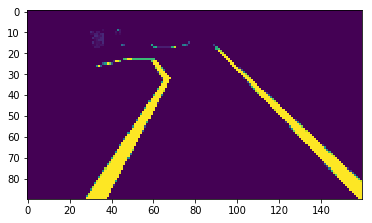

In [3]:
# making sure things are cool and good
n = 100
plt.imshow(img_sets[n][0][0])
plt.show
print(len(img_sets))
print(img_sets[n][0][1])
print(img_sets[n][0][0].shape)

In [5]:
all_dataset = np.concatenate(img_sets, axis=0)
np.random.shuffle(all_dataset)

In [6]:
X_dataset_orig = np.array([data[0] for data in all_dataset[:]])
Y_dataset_orig = np.array([[data[1]] for data in all_dataset]).T

NUMBER_OF_LABELS = 6
CONFIDENCE_THRESHOLD = 0.01

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y
  
# Normalize X (images) dataset
X_dataset = X_dataset_orig/255.

# Convert Y dataset to one-hot encoding
Y_dataset = convert_to_one_hot(Y_dataset_orig, NUMBER_OF_LABELS).T

In [7]:
n, h, w = X_dataset.shape
X_dataset = X_dataset.reshape(n, h, w, 1)
print(X_dataset.shape)

(14766, 90, 160, 1)


In [9]:
VALIDATION_SPLIT = 0.3

print("Total examples: {}\nTraining examples: {}\nTest examples: {}".
      format(X_dataset.shape[0],
             math.ceil(X_dataset.shape[0] * (1-VALIDATION_SPLIT)),
             math.floor(X_dataset.shape[0] * VALIDATION_SPLIT)))
print("X shape: " + str(X_dataset.shape))
print("Y shape: " + str(Y_dataset.shape))

Total examples: 14766
Training examples: 10337.0
Test examples: 4429.0
X shape: (14766, 90, 160, 1)
Y shape: (14766, 6)


In [10]:
# model setup 
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

In [11]:
def reset_weights(model):
    session = backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [19]:
# input_shape needs to match the input, duh
conv_model = models.Sequential()
# this creates our convolution kernel, (3,3) is the size of it
conv_model.add(layers.Conv2D(12, (3, 3), activation='relu',
                             input_shape=(h, w, 1)))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(24, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(36, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(36*36, activation='relu'))
conv_model.add(layers.Dense(36*36, activation='relu'))
conv_model.add(layers.Dense(6, activation='softmax'))

In [20]:
conv_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 88, 158, 12)       120       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 44, 79, 12)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 42, 77, 24)        2616      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 21, 38, 24)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 19, 36, 36)        7812      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 9, 18, 36)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 5832)             

In [21]:
reset_weights(conv_model)

In [67]:
# wandb.init(project='enph353', entity='nullcline')
# config = wandb.config

In [22]:
lr= 1e-4
# config = wandb.config
# config.learning_rate = lr

conv_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(lr=lr),
                   metrics=['acc'])

In [24]:
history_conv = conv_model.fit(X_dataset, Y_dataset, 
                              validation_split=VALIDATION_SPLIT, 
                              epochs=10, 
                              batch_size=200)
                            #

Train on 10336 samples, validate on 4430 samples
Epoch 1/10
10336/10336 [==============================] - 25s 2ms/sample - loss: 0.2524 - acc: 0.9002 - val_loss: 0.2450 - val_acc: 0.9036
Epoch 2/10
10336/10336 [==============================] - 26s 2ms/sample - loss: 0.2504 - acc: 0.9025 - val_loss: 0.2413 - val_acc: 0.9043
Epoch 3/10
10336/10336 [==============================] - 25s 2ms/sample - loss: 0.2477 - acc: 0.9050 - val_loss: 0.2441 - val_acc: 0.9034
Epoch 4/10
10336/10336 [==============================] - 26s 2ms/sample - loss: 0.2443 - acc: 0.9039 - val_loss: 0.2465 - val_acc: 0.9038
Epoch 5/10
10336/10336 [==============================] - 25s 2ms/sample - loss: 0.2423 - acc: 0.9048 - val_loss: 0.2482 - val_acc: 0.9036
Epoch 6/10
10336/10336 [==============================] - 26s 3ms/sample - loss: 0.2402 - acc: 0.9062 - val_loss: 0.2442 - val_acc: 0.9045
Epoch 7/10
10336/10336 [==============================] - 26s 2ms/sample - loss: 0.2383 - acc: 0.9081 - val_loss: 0.2

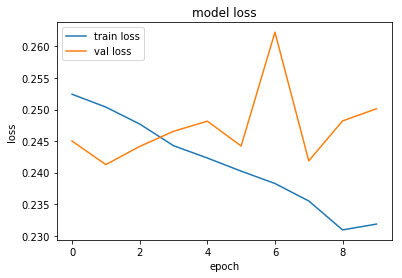

In [25]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

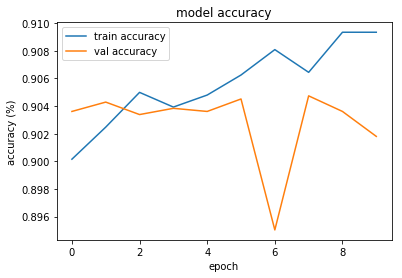

In [26]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

In [27]:
conv_model.save('./models/Xv2.h5')